In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
# import bayes3d.genjax
# import genjax
import pathlib
import numpy as np

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7032/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=20.0
)


b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
IDX = 13
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

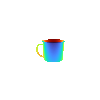

In [5]:
img = b.RENDERER.render(table_pose[None,...], jnp.array([13]))
b.get_depth_image(img[...,2]).convert("RGB")

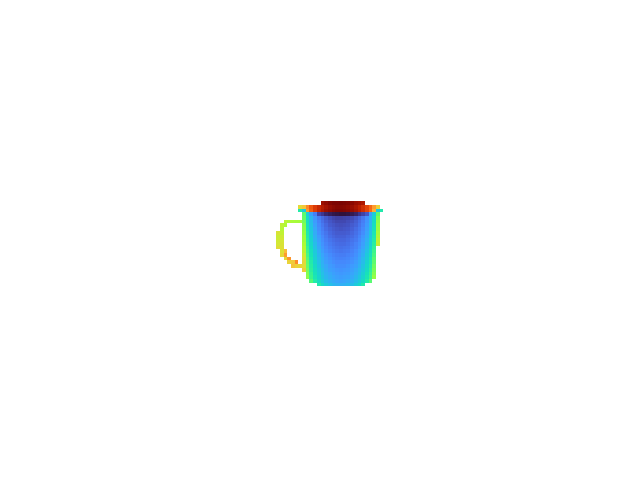

In [6]:
%matplotlib widget
fig, axes = plt.subplots()
b.add_depth_image(axes,img[...,2])
location = (37, 49)
def onclick(event):
    global location
    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))
    location = (x,y)
    print(location)
    axes.axis("on")
    axes.scatter(x,y, c='r', s=10)

fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [7]:
coordinate = img[location[1],location[0],:3]
b.clear()
b.show_cloud("data", img[:,:,:3].reshape(-1,3))
b.show_cloud("point", coordinate.reshape(-1,3), color=b.RED)
coordinate_in_object_frame = b.apply_transform(coordinate.reshape(-1,3), b.t3d.inverse_pose(table_pose))[0]
b.show_cloud("obj", b.RENDERER.meshes[IDX].vertices *5.0)
b.show_cloud("point2", coordinate_in_object_frame.reshape(-1,3) * 5.0, color=b.RED)

In [75]:
random_poses = jax.vmap(b.distributions.gaussian_vmf_jit, in_axes=(0,None, None, None))(jax.random.split(jax.random.PRNGKey(10),2000), table_pose, 0.05, 1.0)
coordinates = jnp.einsum("j,kij->ki", b.add_homogenous_ones(coordinate_in_object_frame), random_poses)
pixel_coordinates = jnp.round(b.camera.project_cloud_to_pixels(coordinates, intrinsics)).astype(jnp.int32)

images = b.RENDERER.render_many(random_poses[:,None,...], jnp.array([13]))
rendered_points = images[jnp.arange(images.shape[0]), pixel_coordinates[:,1], pixel_coordinates[:,0], :3]
distances = jnp.linalg.norm(rendered_points- coordinates[:,:3],axis=-1)
valid_indices = distances < 0.01
images_subset = images[valid_indices]
pixel_coordinates_subset = pixel_coordinates[valid_indices]


filter_size = 6
get_patch = lambda image, coordinate: jax.lax.dynamic_slice(image,
    (coordinate[1]-filter_size, coordinate[0]-filter_size, 0),
    (2*filter_size+1,2*filter_size+1,4))

patches = jax.vmap(get_patch)(images_subset, pixel_coordinates_subset)
patches_centered = jnp.concatenate([patches[...,:3] - patches[:,filter_size,filter_size,:][...,None,None,:3],patches[...,3][...,None]],axis=-1)

valid_indices = jnp.abs(patches_centered[:,:,2]).sum(-1).sum(-1) > 1e-4
images_subset = images_subset[valid_indices]
pixel_coordinates_subset = pixel_coordinates_subset[valid_indices]
patches_centered = patches_centered[valid_indices]

In [78]:
test_poses = jax.vmap(b.distributions.gaussian_vmf_jit, in_axes=(0,None, None, None))(jax.random.split(jax.random.PRNGKey(1000),200), table_pose,  0.05, 1.0)
test_images = b.RENDERER.render_many(test_poses[:,None,...], jnp.array([13]))
coordinates = jnp.einsum("j,kij->ki", b.add_homogenous_ones(coordinate_in_object_frame), test_poses)
pixel_coordinates = jnp.round(b.camera.project_cloud_to_pixels(coordinates, intrinsics)).astype(jnp.int32)

# i = 1
# b.clear()
# b.show_cloud("1",test_images[i,...,:3].reshape(-1,3))
# b.show_cloud("2",coordinates[i,...,:3].reshape(-1,3),color=b.RED)

In [79]:
import PIL
import matplotlib.colors as mcolors

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = PIL.Image.open(buf)
    return img

def generate_heatmap(observed_xyz, heatmaps):
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    
    original_image = observed_xyz[...,2]
    ax.imshow(b.preprocess_for_viz(original_image[filter_size:-filter_size,filter_size:-filter_size])) # cut off edges for filter
    
    best_idx = jnp.unravel_index(heatmaps.argmin(), heatmaps.shape)
    
    c_white = mcolors.colorConverter.to_rgba('white',alpha = 0)
    c_red= mcolors.colorConverter.to_rgba('red',alpha = 1)
    cmap_rb = mcolors.LinearSegmentedColormap.from_list('rb_cmap',[c_red,c_white],512)
    
    hmap = jnp.log(heatmaps[best_idx[0]])
    ax.imshow(hmap, cmap_rb, alpha=0.75)

    ax.scatter(best_idx[2], best_idx[1],color="black", marker='x', alpha=1) # plot the pose point 
    #ax.axis('off')
    
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(b.preprocess_for_viz(original_image[filter_size:-filter_size,filter_size:-filter_size])) # cut off edges for filter
    
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(hmap, cmap_rb)
    
    img_PIL = fig2img(fig)
    return img_PIL

In [128]:
def get_error_between_patches(slice_centered, patch):
    assert slice_centered.shape[-1] == 4
    assert patch.shape[-1] == 4

    # far_mask_slice_centered = (slice_centered[...,2] > 10.0)[...,None]
    # far_mask_patch = (patch[...,2] > 10.0)[...,None]

    far_mask_slice_centered = (slice_centered[...,3] < 0.5)[...,None]
    far_mask_patch = (patch[...,3] < 0.5)[...,None]


    slice_centered = slice_centered * (1.0 - far_mask_slice_centered) + 1000.0 * far_mask_slice_centered
    patch = patch * (1.0 - far_mask_patch) + 1000.0 * far_mask_patch

    distances = jnp.linalg.norm(slice_centered[...,:3] - patch[...,:3], axis=-1)
    width = 0.005
    probabilities_per_pixel = (distances > width/2)
    return probabilities_per_pixel.sum()
    
get_error_between_patches_parallel_patches = jax.vmap(get_error_between_patches, in_axes=(None, 0))

@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(1,2,),
)
def compute_error(ij, observed_xyz_padded, patch):
    slice = jax.lax.dynamic_slice(observed_xyz_padded, (ij[0], ij[1], 0), (2*filter_size + 1, 2*filter_size + 1, 4))
    slice_centered = jnp.concatenate([slice[...,:3] - slice[filter_size, filter_size,:3], slice[...,3][...,None]], axis=-1)
    # slice_centered = slice - slice[filter_size, filter_size,:]
    return get_error_between_patches(slice_centered, patch)


def get_errors(observed_xyz, template):
    observed_xyz_padded = jax.lax.pad(observed_xyz,  -100.0, ((filter_size,filter_size,0,),(filter_size,filter_size,0,),(0,0,0,)))
    jj, ii = jnp.meshgrid(jnp.arange(observed_xyz.shape[1]), jnp.arange(observed_xyz.shape[0]))
    indices = jnp.stack([ii,jj],axis=-1)
    heatmap = compute_error(indices, observed_xyz_padded, template)
    return heatmap

    
get_errors_jit = jax.jit(get_errors)
get_errors_vmap_jit = jax.jit(jax.vmap(get_errors, in_axes=(None, 0)))

In [129]:
i = 35
observed_xyz = test_images[i,...]
heatmaps = get_errors_vmap_jit(observed_xyz, patches_centered)[:, filter_size:-filter_size,filter_size:-filter_size]
heatmaps

Array([[[103, 103, 103, ..., 103, 103, 103],
        [103, 103, 103, ..., 103, 103, 103],
        [103, 103, 103, ..., 103, 103, 103],
        ...,
        [103, 103, 103, ..., 103, 103, 103],
        [103, 103, 103, ..., 103, 103, 103],
        [103, 103, 103, ..., 103, 103, 103]],

       [[ 57,  57,  57, ...,  57,  57,  57],
        [ 57,  57,  57, ...,  57,  57,  57],
        [ 57,  57,  57, ...,  57,  57,  57],
        ...,
        [ 57,  57,  57, ...,  57,  57,  57],
        [ 57,  57,  57, ...,  57,  57,  57],
        [ 57,  57,  57, ...,  57,  57,  57]],

       [[ 86,  86,  86, ...,  86,  86,  86],
        [ 86,  86,  86, ...,  86,  86,  86],
        [ 86,  86,  86, ...,  86,  86,  86],
        ...,
        [ 86,  86,  86, ...,  86,  86,  86],
        [ 86,  86,  86, ...,  86,  86,  86],
        [ 86,  86,  86, ...,  86,  86,  86]],

       ...,

       [[ 63,  63,  63, ...,  63,  63,  63],
        [ 63,  63,  63, ...,  63,  63,  63],
        [ 63,  63,  63, ...,  63,  63,  63

In [131]:
i = 35
observed_xyz = test_images[i,...]
observed_xyz_padded = jax.lax.pad(observed_xyz,  -100.0, ((filter_size,filter_size,0,),(filter_size,filter_size,0,),(0,0,0,)))
ij = jnp.array([20,20])
slice = jax.lax.dynamic_slice(observed_xyz_padded, (ij[0], ij[1], 0), (2*filter_size + 1, 2*filter_size + 1, 4))
slice_centered = jnp.concatenate([slice[...,:3] - slice[filter_size, filter_size,:3], slice[...,3][...,None]], axis=-1)
mask1 = (slice_centered[...,2] > 10.0)[...,None]
mask2 = (slice_centered[...,3] < 0.5)[...,None]
assert (mask1 == mask2).all()
generate_heatmap(observed_xyz)

AssertionError: 

In [118]:
slice_centered

Array([[[-0.60000014, -0.60000014,  0.        ,  0.        ],
        [-0.50000024, -0.60000014,  0.        ,  0.        ],
        [-0.40000033, -0.60000014,  0.        ,  0.        ],
        [-0.29999995, -0.60000014,  0.        ,  0.        ],
        [-0.20000005, -0.60000014,  0.        ,  0.        ],
        [-0.10000014, -0.60000014,  0.        ,  0.        ],
        [ 0.        , -0.60000014,  0.        ,  0.        ],
        [ 0.0999999 , -0.60000014,  0.        ,  0.        ],
        [ 0.19999981, -0.60000014,  0.        ,  0.        ],
        [ 0.29999995, -0.60000014,  0.        ,  0.        ],
        [ 0.39999986, -0.60000014,  0.        ,  0.        ],
        [ 0.49999976, -0.60000014,  0.        ,  0.        ],
        [ 0.5999999 , -0.60000014,  0.        ,  0.        ]],

       [[-0.60000014, -0.50000024,  0.        ,  0.        ],
        [-0.50000024, -0.50000024,  0.        ,  0.        ],
        [-0.40000033, -0.50000024,  0.        ,  0.        ],
      

In [113]:
slice_centered

Array([[[-0.59999967, -0.59999967,  0.        ,  0.        ],
        [-0.49999976, -0.59999967,  0.        ,  0.        ],
        [-0.39999986, -0.59999967,  0.        ,  0.        ],
        [-0.2999997 , -0.59999967,  0.        ,  0.        ],
        [-0.19999981, -0.59999967,  0.        ,  0.        ],
        [-0.0999999 , -0.59999967,  0.        ,  0.        ],
        [ 0.        , -0.59999967,  0.        ,  0.        ],
        [ 0.10000014, -0.59999967,  0.        ,  0.        ],
        [ 0.20000005, -0.59999967,  0.        ,  0.        ],
        [ 0.29999995, -0.59999967,  0.        ,  0.        ],
        [ 0.40000033, -0.59999967,  0.        ,  0.        ],
        [ 0.50000024, -0.59999967,  0.        ,  0.        ],
        [ 0.60000014, -0.59999967,  0.        ,  0.        ]],

       [[-0.59999967, -0.49999976,  0.        ,  0.        ],
        [-0.49999976, -0.49999976,  0.        ,  0.        ],
        [-0.39999986, -0.49999976,  0.        ,  0.        ],
      

In [111]:
mask1[...,0]

Array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False],
       [False, False, False,

In [112]:
mask2[...,0]

Array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True],
       [ True,  True,  True,

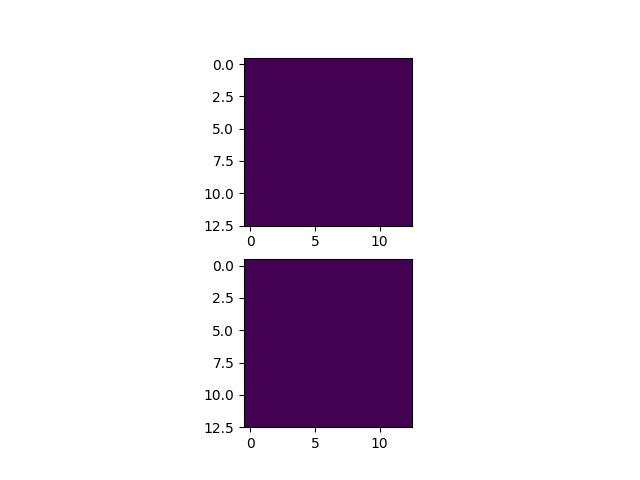

In [110]:
f, ax = plt.subplots(2)
ax[0].imshow(mask1[...,0])
ax[1].imshow(mask2[...,0])


In [ ]:
# TODO:
#  1. Fix hack on far plane points in the template and in the slce of the observed iamge.
#  2. Make heatmap visualization. ON left is observed image. On right is red heatmap. Overlayed on image is the best match.
#  3. Make mp4 showing the heatmpas from step 2 across hundreds of test images.
# (See bayes3d/scripts/experiments/likelihood_debug/scene_parse.ipynb)